# Basic Imports

In [81]:
# Basic Imports
import datetime
import math
import os
import sys
from pathlib import Path
import random
import pickle
import urllib.request
import numpy as np
import pandas as pd
from multi_modal_constants import *
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cv2

# PyTorch related imports....
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision.transforms.functional as TF
import torchvision
from torchvision import datasets, models, transforms
import time
from tempfile import TemporaryDirectory
import models_vit
import models_mae
from rFmodel import *
from data_loader import *
import pandas as pd
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, BinaryClassifierOutputTarget



device = "cuda" if torch.cuda.is_available() else "cpu"

In [31]:
fundus_model_weights = torch.load("/tscc/nfs/home/vejoshi/oct_fundus_project/ret_found_exp/RETFound_MAE/experiments/best_fundus/retFoundretFound_shape_224_dp_0.1_lr_0.0005_run_0.pt",
                                  map_location = device)

fundus_model = build_model()
fundus_model.load_state_dict(fundus_model_weights, strict=False)
fundus_model = fundus_model.to("cuda")
fundus_model.eval()

classificationModel(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(appro

In [32]:
intermediate_outputs = {}

# Function to register forward hook
def get_intermediate_output(name):
    def hook(model, input, output):
        intermediate_outputs[name] = output
    return hook

# Register forward hooks for each layer
for ln in range(24):
    fundus_model.model.blocks[ln].attn.q_norm.register_forward_hook(get_intermediate_output('norm_query_'+str(ln)))
    fundus_model.model.blocks[ln].attn.k_norm.register_forward_hook(get_intermediate_output('norm_key_'+str(ln)))

In [33]:
test_img = "/tscc/nfs/home/vejoshi/oct_fundus_project/oct_fundus_dataset/fundus_images/SD2154_OS_075808_2.tif"
pre_proc_func = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
img = PIL.Image.open(test_img).convert('RGB').resize((224,224))

In [34]:
t_img = pre_proc_func(img)
op = fundus_model(torch.unsqueeze(t_img, dim = 0).to(device))

In [35]:
def multi_head_att(intermediate_outputs, ln = 0, att_head_val = 0):
    cls_query = intermediate_outputs["norm_query_"+str(ln)][0, att_head_val, 0, :]
    key_vals  = intermediate_outputs["norm_key_"+str(ln)][0,att_head_val,1:,:]
    att_tmp = torch.nn.functional.softmax(cls_query @ key_vals.transpose(-2, -1), dim = 0)
    heatmap_tmp = torch.reshape(att_tmp, (14,14))
    return heatmap_tmp

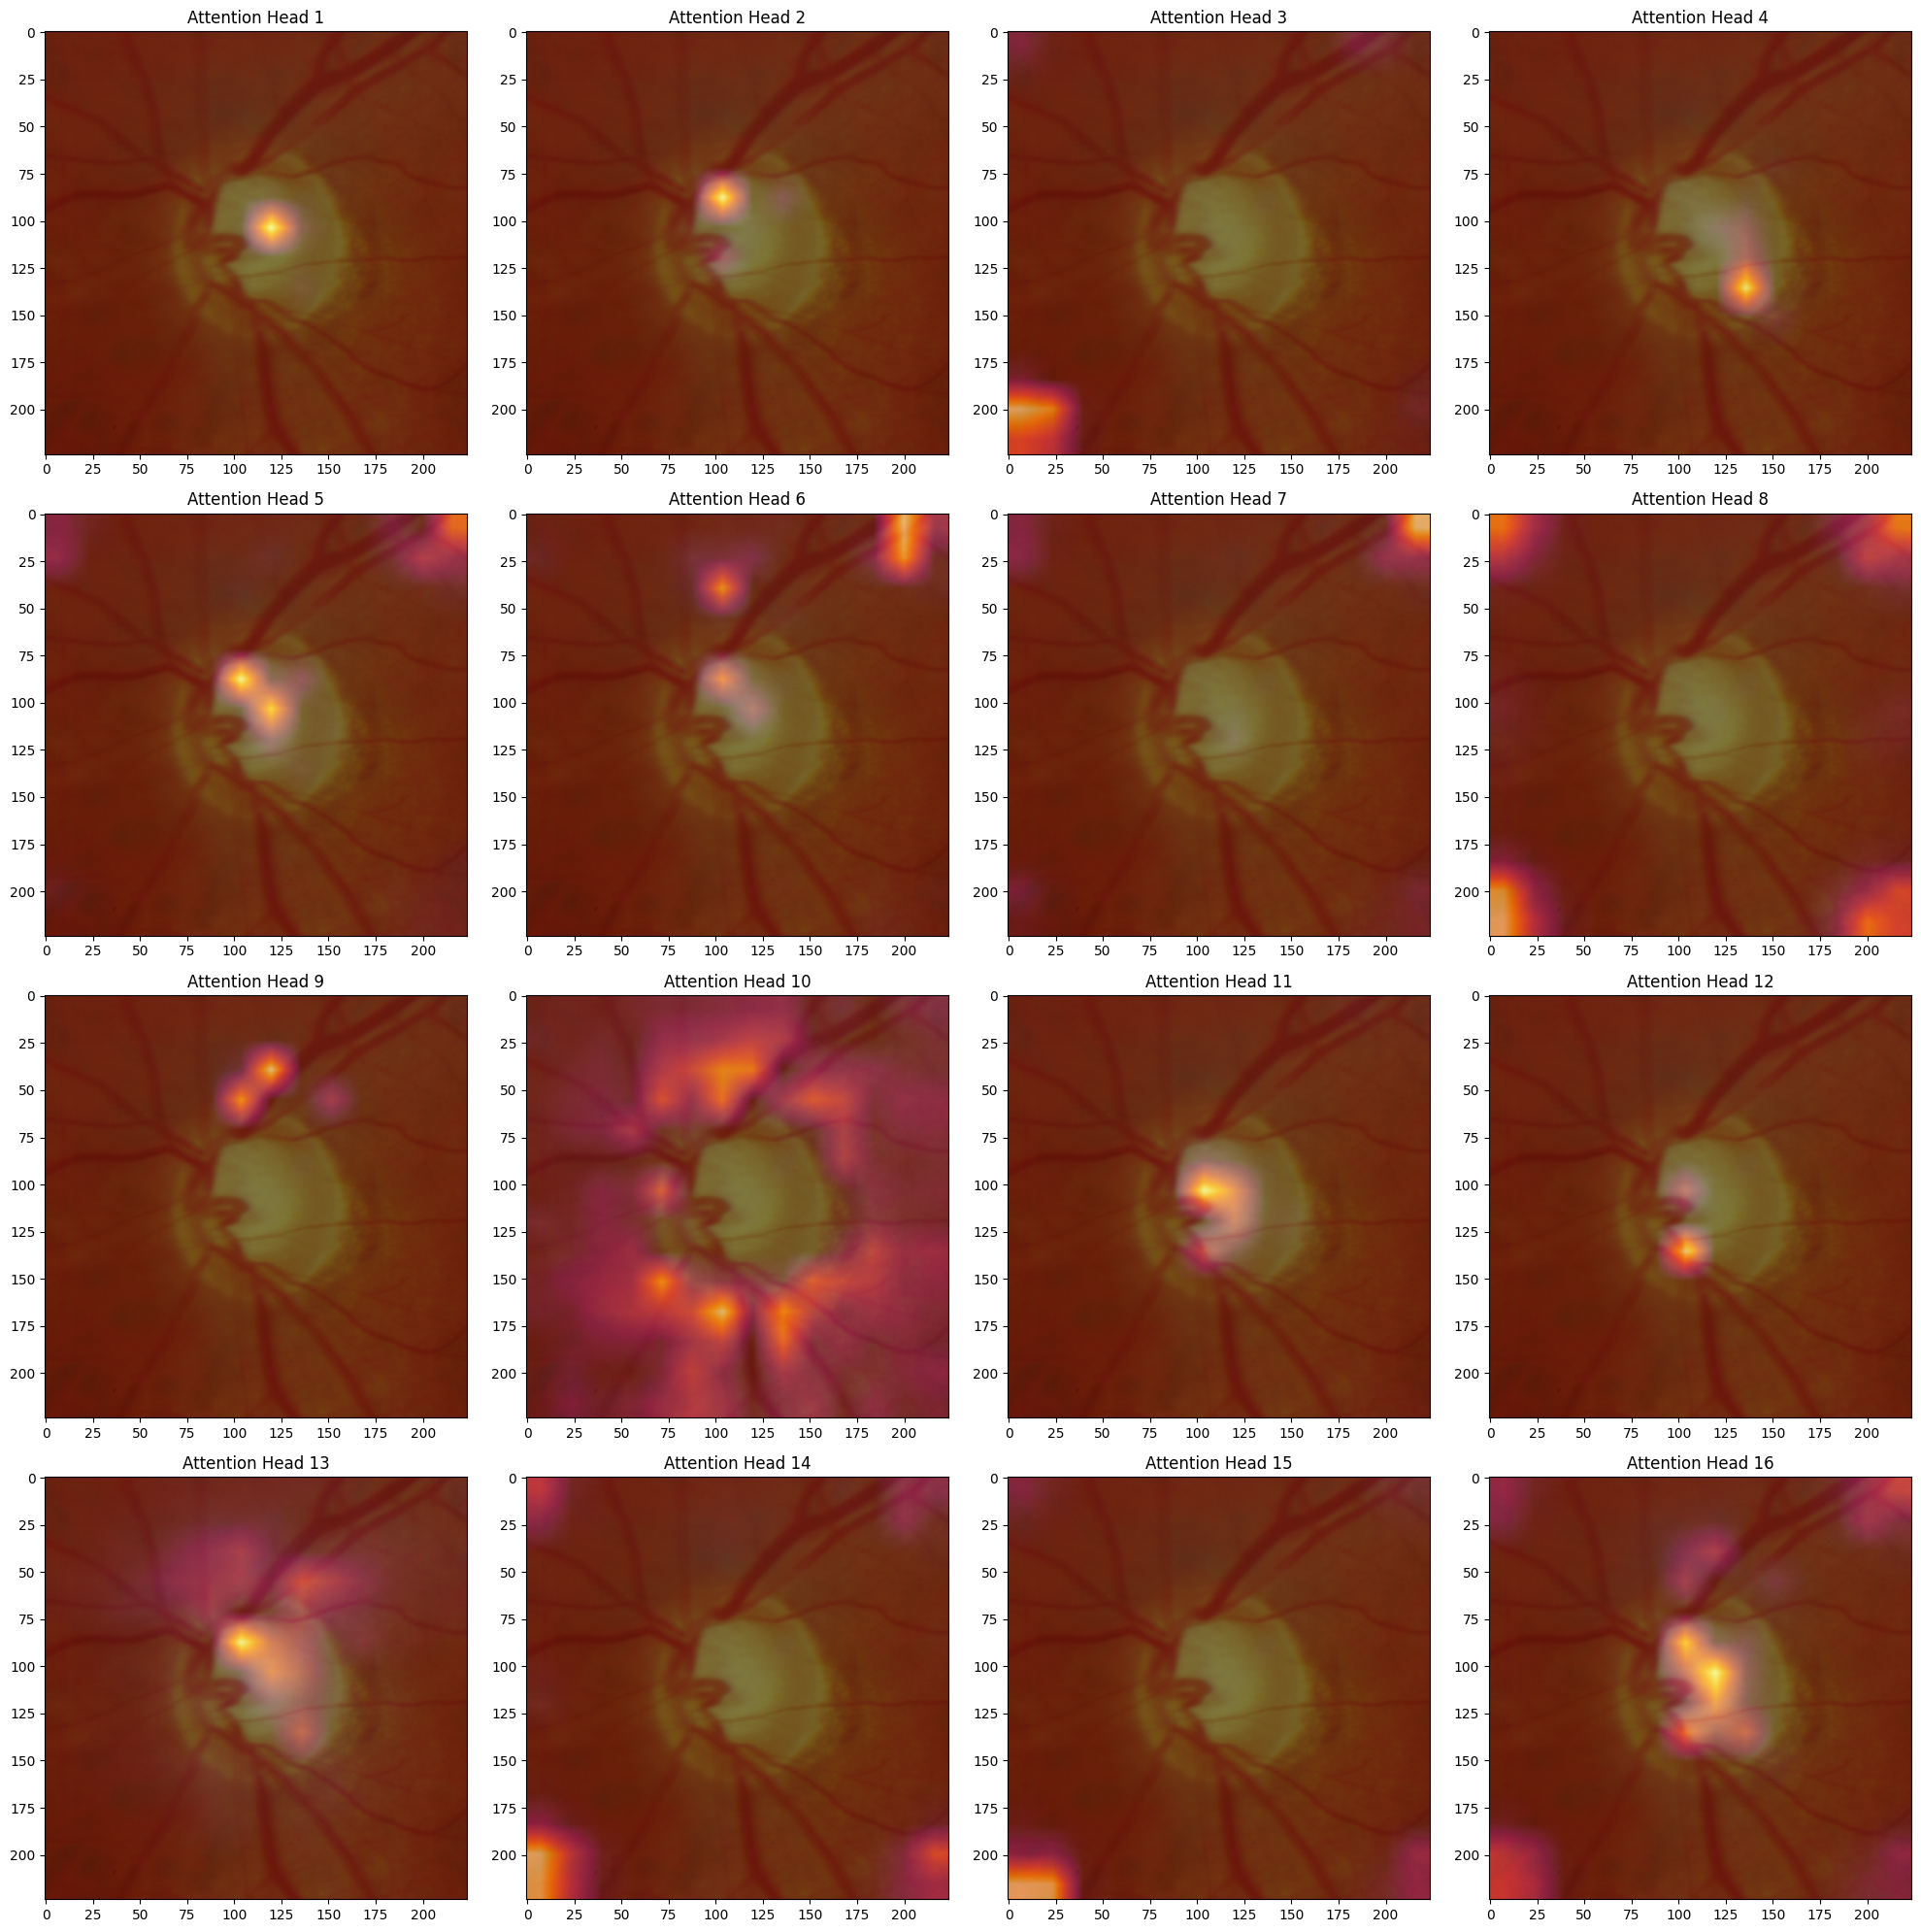

In [36]:
# healthy case...
# Create a figure and a set of subplots
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

# Flatten the axs array to iterate over each subplot
axs = axs.flatten()

# Iterate over each subplot and plot data
net_amp = np.zeros((224,224))
for i, ax in enumerate(axs):
    maps = multi_head_att(intermediate_outputs, ln = 0,att_head_val = i)
    att_map = cv2.resize(maps.detach().cpu().numpy(), (224,224))
    net_amp+=att_map
    ax.imshow(img)
    ax.imshow(att_map, cmap='inferno', alpha=0.5)
    ax.set_title(f'Attention Head {i+1}')  # Set title for each subplot
    ax.grid(False)

#net_amp = net_amp / np.linalg.norm(net_amp)

plt.imshow(img)
plt.imshow(net_amp, cmap='inferno', alpha=0.5)


# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Display the plot
plt.show()

In [94]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result
    
cam = GradCAMPlusPlus(model=fundus_model, 
        target_layers=[fundus_model.model.blocks[2].norm1], 
        reshape_transform=reshape_transform)

grayscale_cam = cam(input_tensor=torch.unsqueeze(t_img, dim = 0).to(device), 
                    targets=[BinaryClassifierOutputTarget(1)])

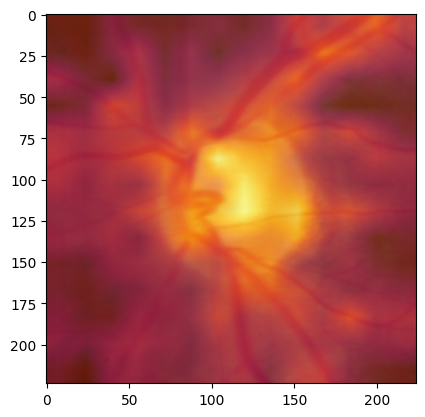

In [95]:
plt.imshow(img)
plt.imshow(grayscale_cam[0,:,:], cmap='inferno', alpha=0.5)

# Glaucoma Case

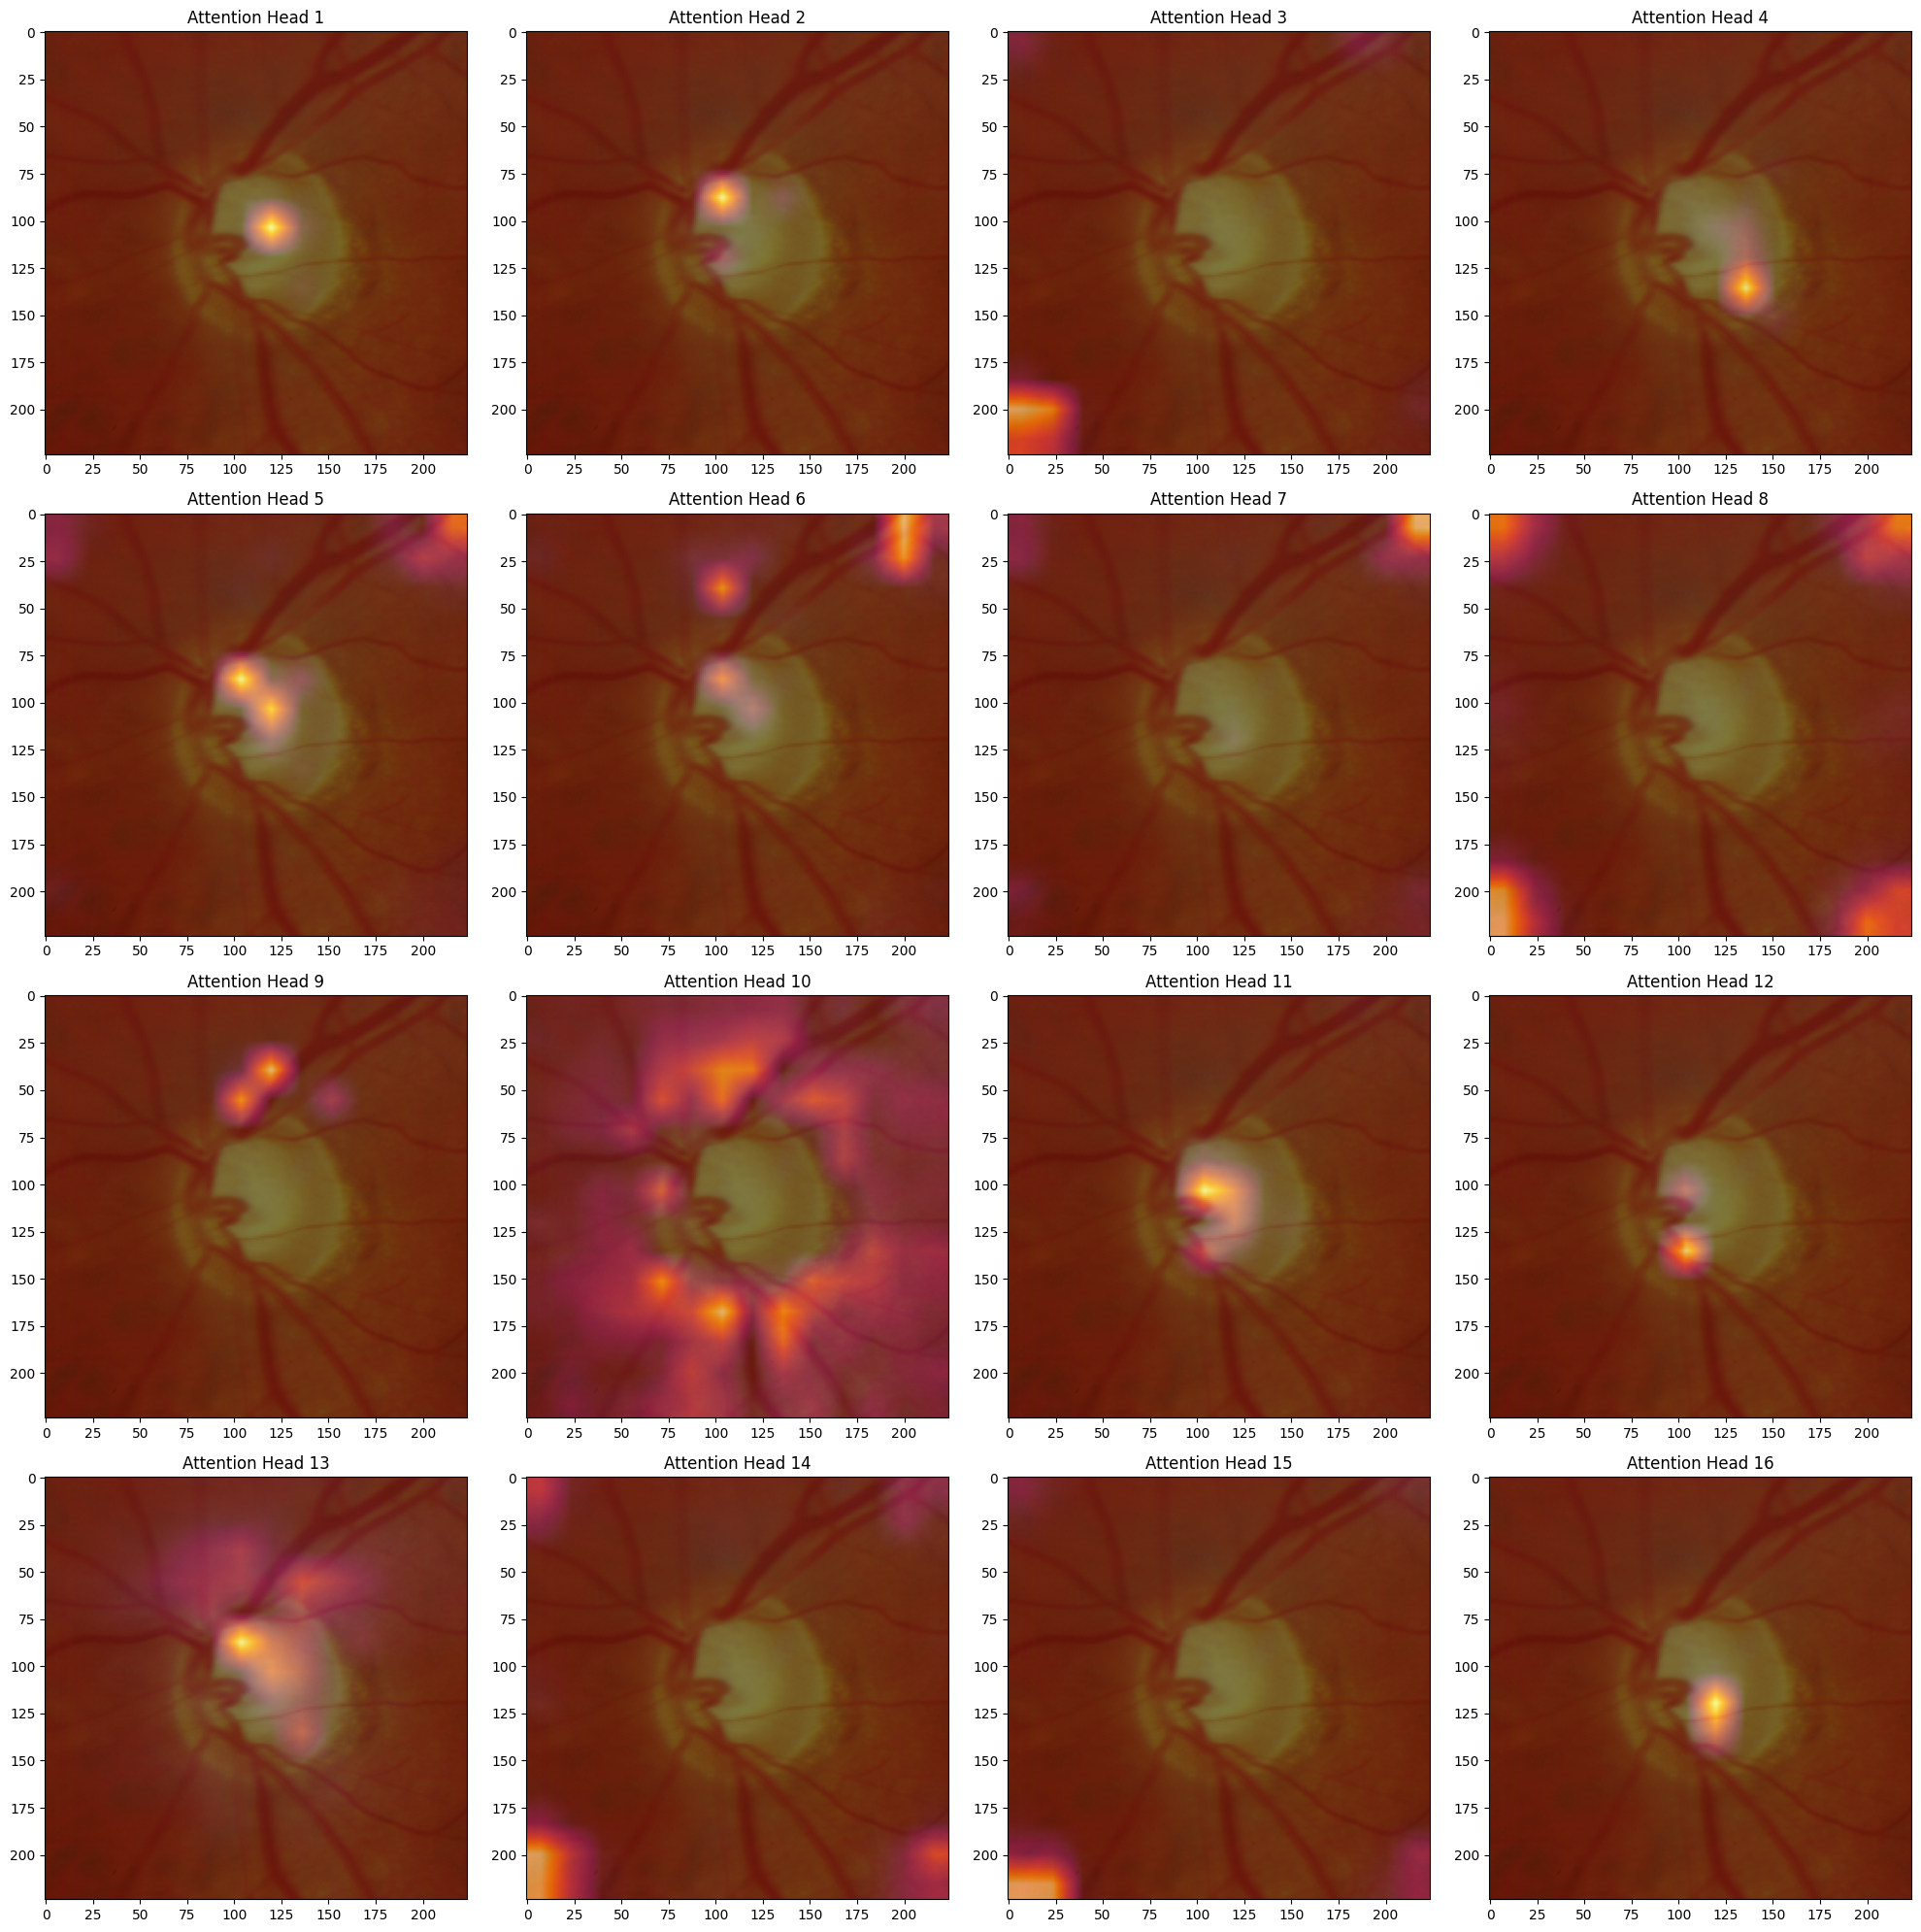

In [85]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

# Flatten the axs array to iterate over each subplot
axs = axs.flatten()

# Iterate over each subplot and plot data\
for i, ax in enumerate(axs):
    maps = multi_head_att(intermediate_outputs, att_head_val = i)
    att_map = cv2.resize(maps.detach().cpu().numpy(), (224,224))
    ax.imshow(img)
    ax.imshow(att_map, cmap='inferno', alpha=0.5)
    ax.set_title(f'Attention Head {i+1}')  # Set title for each subplot
    ax.grid(False)

# Adjust layout to prevent overlapping titles
plt.tight_layout()
plt.savefig('glaucoma_layer_1_attention_head_viz.png')

# Display the plot
plt.show()

# OCT model

In [86]:
oct_model_weights = torch.load("/tscc/nfs/home/vejoshi/oct_fundus_project/ret_found_exp/RETFound_MAE/experiments/best_oct/retFoundretFound_shape_224_dp_0.1_lr_0.0005_run_0.pt",
                               map_location = "cuda")
oct_model = build_model()
oct_model.load_state_dict(oct_model_weights, strict=False)
oct_model = oct_model.to("cuda")
oct_model.eval()

classificationModel(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(appro

In [87]:
intermediate_outputs = {}

# Function to register forward hook
def get_intermediate_output(name):
    def hook(model, input, output):
        intermediate_outputs[name] = output
    return hook

# Register forward hooks for each layer
oct_model.model.blocks[0].attn.q_norm.register_forward_hook(get_intermediate_output('norm_query_1'))
oct_model.model.blocks[0].attn.k_norm.register_forward_hook(get_intermediate_output('norm_key_1'))
oct_model.model.blocks[0].attn.qkv.register_forward_hook(get_intermediate_output('qkv_1'))

test_img = "/tscc/nfs/home/vejoshi/oct_fundus_project/oct_fundus_dataset/oct_images/SD2154_S_10488_0.tif"
pre_proc_func = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
img = PIL.Image.open(test_img).convert('RGB').resize((224,224))

In [88]:
t_img = pre_proc_func(img)
op = oct_model(torch.unsqueeze(t_img, dim = 0).to(device))

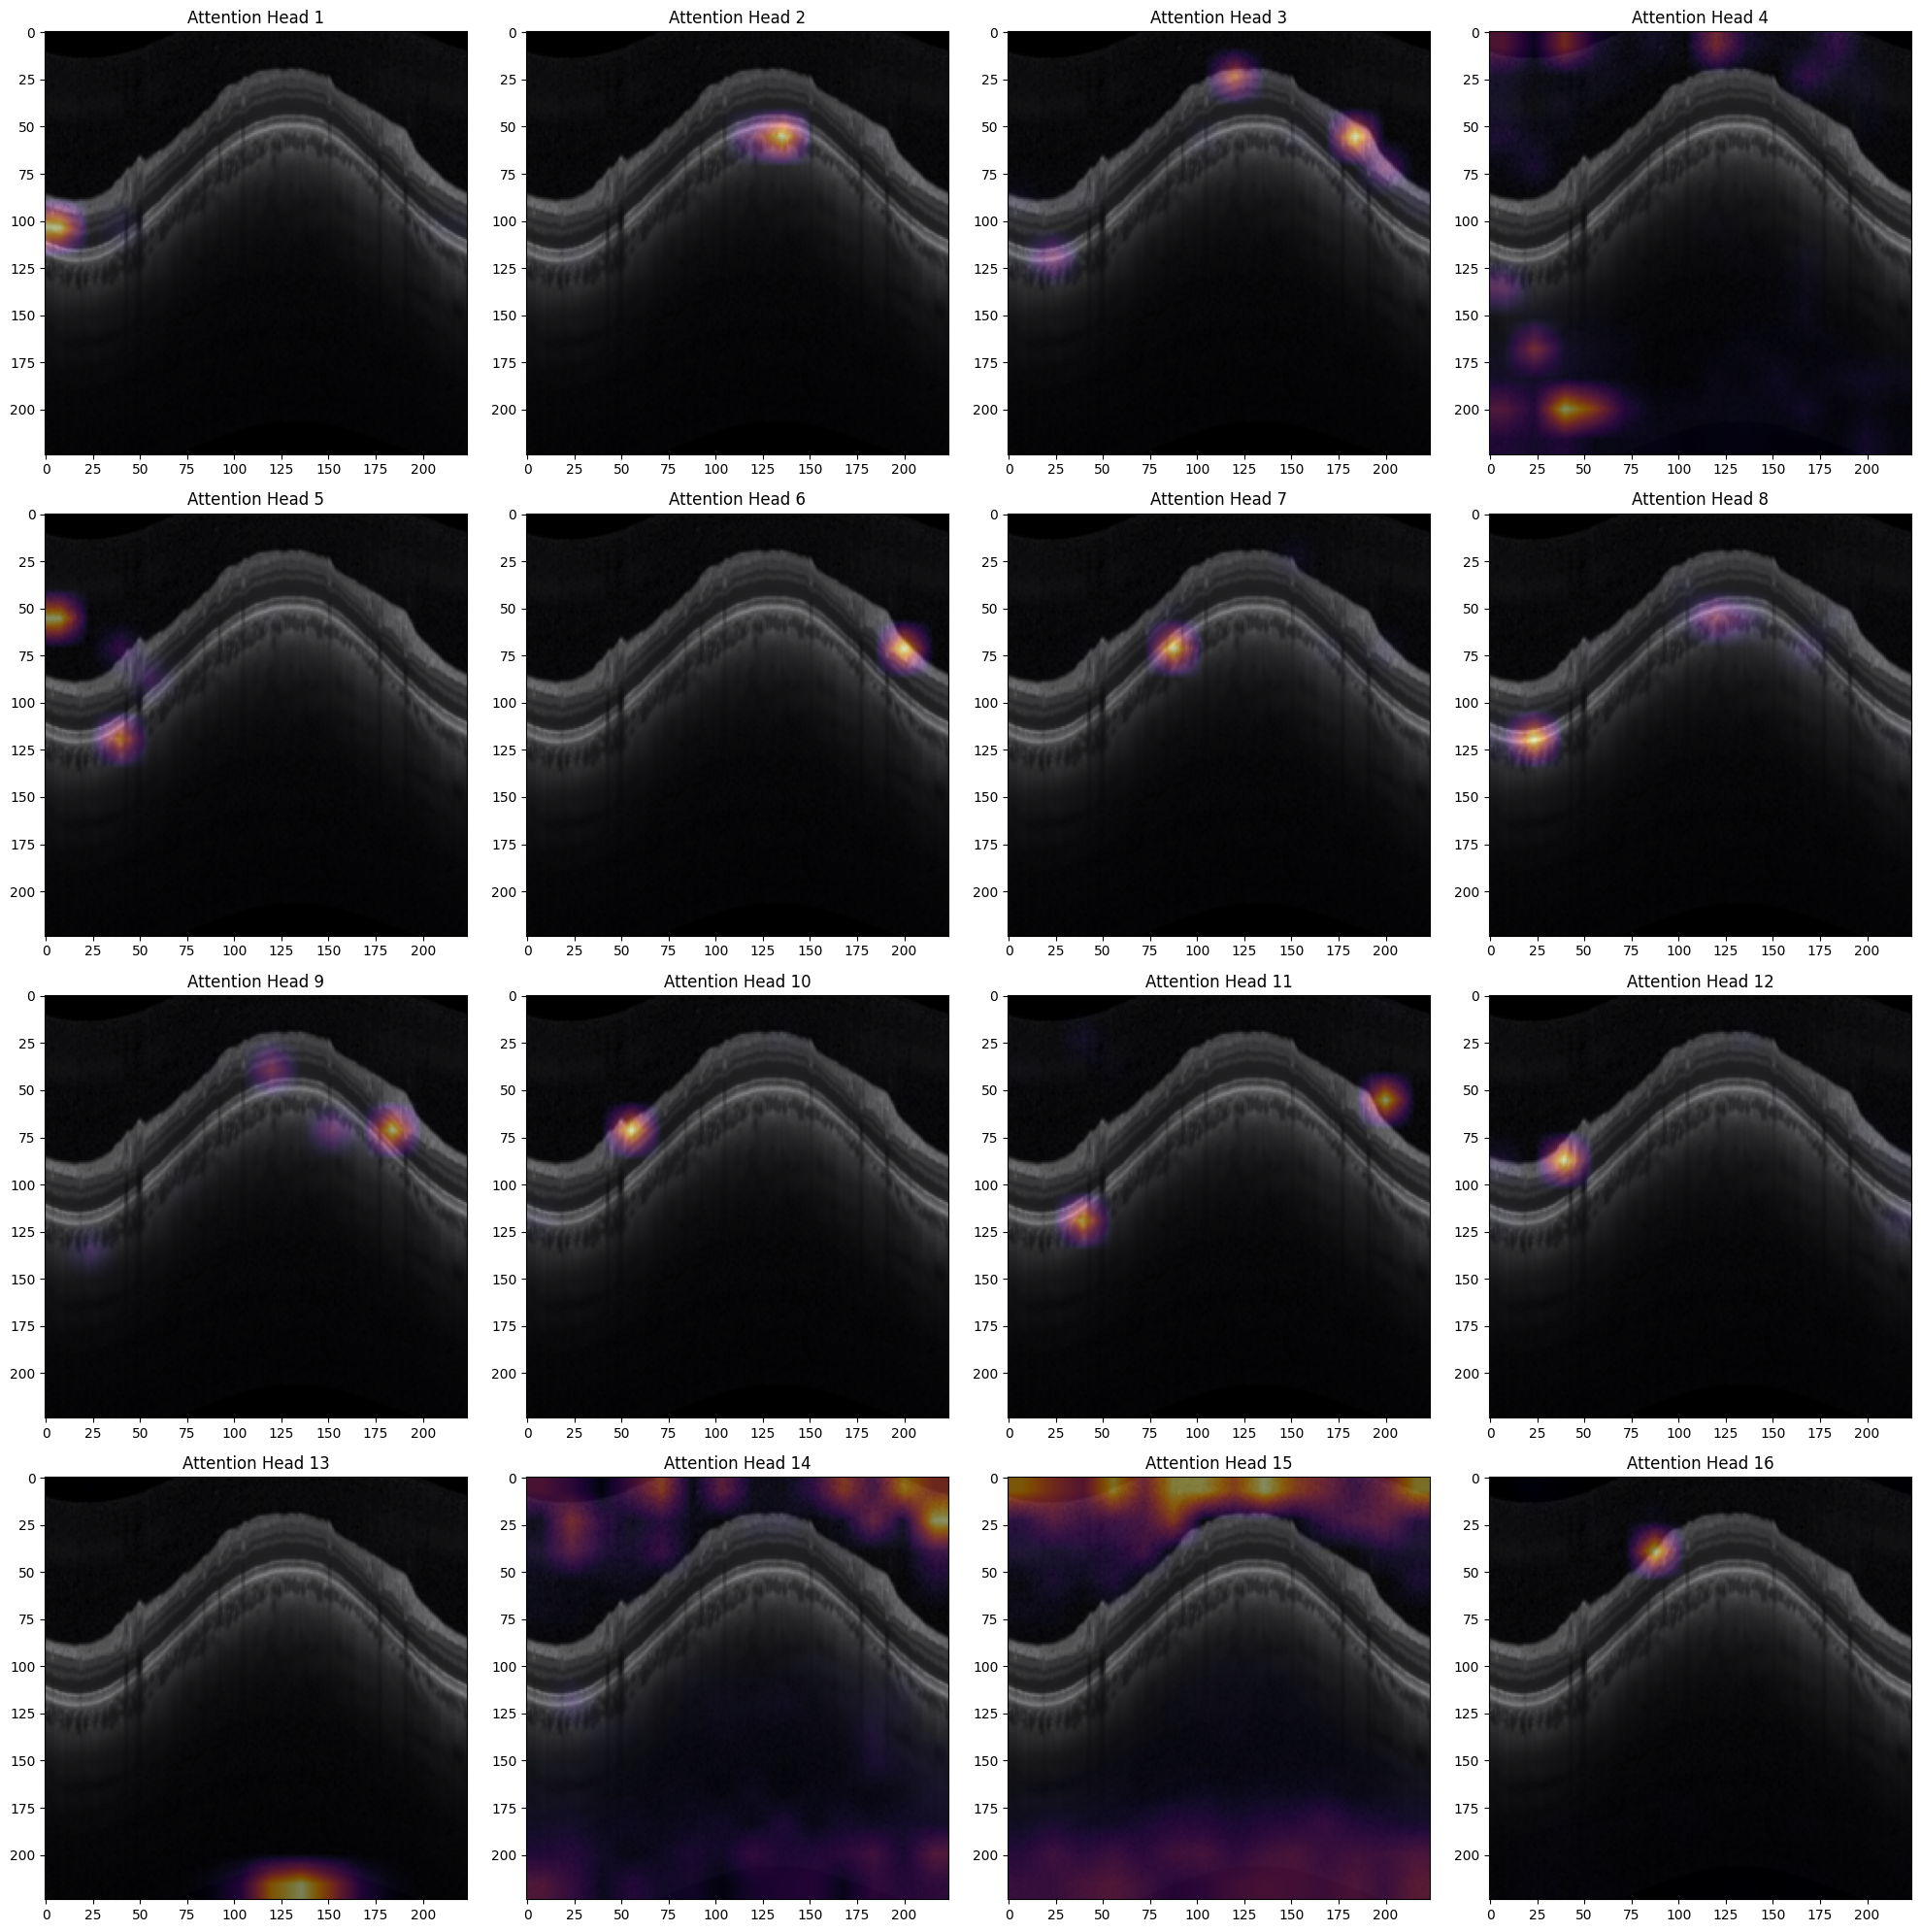

In [89]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

# Flatten the axs array to iterate over each subplot
axs = axs.flatten()

# Iterate over each subplot and plot data\
for i, ax in enumerate(axs):
    maps = multi_head_att(intermediate_outputs, att_head_val = i)
    att_map = cv2.resize(maps.detach().cpu().numpy(), (224,224))
    ax.imshow(img)
    ax.imshow(att_map, cmap='inferno', alpha=0.5)
    ax.set_title(f'Attention Head {i+1}')  # Set title for each subplot
    ax.grid(False)

# Adjust layout to prevent overlapping titles
plt.tight_layout()
plt.savefig('oct_glaucoma_layer_1_attention_head_viz.png')

# Display the plot
plt.show()